In [1]:
import baseline_features as bfeat
import baseline_ml as bml
import soundfile
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from baseline_features import extract_features, aggregate_feature_per_file, normalize_zscore

In [19]:
def get_features(file, feature_list):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        features = extract_features(waveform, 2048, 512, sample_rate, feature_list)
        feature_matrix = aggregate_feature_per_file(features)
                
        return feature_matrix



In [20]:
def get_sweetness(file_name):
    melon_num = int(file_name.split("P")[0].split("M")[1])
    not_sweet = [1, 2, 8, 11, 13, 14, 17, 18, 19, 20, 22, 25]
    somewhat_sweet = [23, 29]
    sweet = [3, 4, 5, 6, 7, 10, 15, 16, 21, 27]
    very_sweet = [9, 12, 24, 26, 28, 30]
    
    if melon_num in not_sweet:
        sweetness = "Not Sweet"
    elif melon_num in somewhat_sweet:
        sweetness = "Somewhat Sweet"
    elif melon_num in sweet:
        sweetness = "Sweet"
    elif melon_num in very_sweet:
        sweetness = "Very Sweet"

    
    return sweetness

In [21]:
def get_sweetness_binary(file_name):
    melon_num = int(file_name.split("P")[0].split("M")[1])
    not_sweet = [1, 2, 8, 11, 13, 14, 17, 18, 19, 20, 22, 25]
    somewhat_sweet = [23, 29]
    sweet = [3, 4, 5, 6, 7, 10, 15, 16, 21, 27]
    very_sweet = [9, 12, 24, 26, 28, 30]
    
    if melon_num in not_sweet or melon_num in somewhat_sweet:
        sweetness = "Bad"
    elif melon_num in sweet or melon_num in very_sweet:
        sweetness = "Good"


    
    return sweetness

In [22]:
def load_data(feature_list, binary=True):
    X,y=[],[]
    count = 0
    for file in tqdm(os.listdir("Melon_Audio")):
        file_name=os.path.basename(file)
        if binary:
            sweetness = get_sweetness_binary(file_name)
        else:
            sweetness = get_sweetness(file_name)
        features = get_features(os.path.join("Melon_Audio", file), feature_list)
        X.append(features)
        y.append(sweetness)
        #count += 1
        # '\r' + end='' results in printing over same line
        #print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [23]:
for feat in ["spectral_centroid", "rms", "zcr", "spectral_crest", "spectral_flux", "ste"]:
    feat = [feat]
    features, labels = load_data(feat)
    features = np.squeeze(features)
    scaler = bfeat.get_z_score_scaler(features)
    norm_features = bfeat.normalize_features(features, scaler)
    X_train, X_test, y_train, y_test = train_test_split(
        norm_features, 
        labels, 
        test_size=0.2, 
        random_state=69
    )
    classification_models = [
        KNeighborsClassifier(),#(3),
        SVC(kernel='linear'),#, C=0.025),
        SVC(kernel='rbf'),
        DecisionTreeClassifier(),#max_depth=5),
        RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
    print("\n", feat)
    display(scores_df)

100%|████████████████████████████████████████| 360/360 [00:03<00:00, 108.39it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_centroid']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,41.67%,0.4125874125874126,0.4166666666666667,0.41802641802641805,0.4125,0.413312693498452
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,40.28%,0.4017391304347826,0.4027777777777778,0.4045088566827697,0.403125,0.40424710424710425
3,DecisionTreeClassifier,50.00%,0.4996138996138997,0.5,0.5011583011583012,0.503125,0.5030959752321982
4,RandomForestClassifier,44.44%,0.44272445820433437,0.4444444444444444,0.4461644306845545,0.44375,0.4444444444444444
5,AdaBoostClassifier,41.67%,0.4125874125874126,0.4166666666666667,0.41802641802641805,0.4125,0.413312693498452
6,GaussianNB,48.61%,0.4277121374865735,0.4861111111111111,0.4480248239646736,0.45625,0.4401069518716577
7,QuadraticDiscriminantAnalysis,44.44%,0.375,0.4444444444444444,0.39814814814814814,0.4125,0.375


100%|████████████████████████████████████████| 360/360 [00:00<00:00, 772.62it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['rms']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,55.56%,0.5541795665634675,0.5555555555555556,0.5569315445476436,0.55625,0.5555555555555556
1,SVC,52.78%,0.4791489361702128,0.5277777777777778,0.49683215130023645,0.5,0.5
2,SVCRBF kernel,58.33%,0.5404255319148936,0.5833333333333334,0.5560283687943263,0.55625,0.5740740740740741
3,DecisionTreeClassifier,50.00%,0.4996138996138997,0.5,0.5011583011583012,0.503125,0.5030959752321982
4,RandomForestClassifier,56.94%,0.568695652173913,0.5694444444444444,0.5706924315619967,0.571875,0.5710424710424711
5,AdaBoostClassifier,52.78%,0.5184893784421715,0.5277777777777778,0.5259200979106565,0.51875,0.519047619047619
6,GaussianNB,48.61%,0.4383301707779885,0.4861111111111111,0.45653243376203523,0.459375,0.44836146971201585
7,QuadraticDiscriminantAnalysis,51.39%,0.45864661654135336,0.5138888888888888,0.47786131996658315,0.484375,0.47860962566844917


100%|████████████████████████████████████████| 360/360 [00:00<00:00, 688.36it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['zcr']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,50.00%,0.49375,0.5,0.5,0.49375,0.49375
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,48.61%,0.4383301707779885,0.4861111111111111,0.45653243376203523,0.459375,0.44836146971201585
3,DecisionTreeClassifier,41.67%,0.40519276160503537,0.4166666666666667,0.4143718856543404,0.40625,0.40476190476190477
4,RandomForestClassifier,45.83%,0.44007976071784644,0.4583333333333333,0.4513127284812229,0.44375,0.4407407407407407
5,AdaBoostClassifier,45.83%,0.44007976071784644,0.4583333333333333,0.4513127284812229,0.44375,0.4407407407407407
6,GaussianNB,48.61%,0.4836208567551852,0.4861111111111111,0.4796364497857036,0.5,0.5
7,QuadraticDiscriminantAnalysis,44.44%,0.444015444015444,0.4444444444444444,0.44573144573144574,0.446875,0.4473684210526316


100%|████████████████████████████████████████| 360/360 [00:03<00:00, 109.99it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_crest']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,50.00%,0.49650349650349657,0.5,0.5011655011655012,0.496875,0.4969040247678019
1,SVC,48.61%,0.4836208567551851,0.4861111111111111,0.48760526372466667,0.484375,0.4845559845559846
2,SVCRBF kernel,55.56%,0.5259259259259259,0.5555555555555556,0.5390946502057613,0.534375,0.54
3,DecisionTreeClassifier,47.22%,0.46853146853146854,0.4722222222222222,0.47345247345247343,0.46875,0.46904024767801855
4,RandomForestClassifier,51.39%,0.5137950993633031,0.5138888888888888,0.5145454155679894,0.51875,0.5186480186480187
5,AdaBoostClassifier,51.39%,0.5115332428765265,0.5138888888888888,0.5153022764963064,0.5125,0.5123552123552123
6,GaussianNB,51.39%,0.4343434343434343,0.5138888888888888,0.4579124579124579,0.478125,0.46349413298565845
7,QuadraticDiscriminantAnalysis,47.22%,0.4571428571428572,0.4722222222222222,0.4470899470899471,0.496875,0.49615384615384617


100%|████████████████████████████████████████| 360/360 [00:03<00:00, 107.51it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,47.22%,0.46853146853146854,0.4722222222222222,0.47345247345247343,0.46875,0.46904024767801855
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,51.39%,0.4686907020872865,0.5138888888888888,0.4859090589640874,0.4875,0.484111221449851
3,DecisionTreeClassifier,52.78%,0.5263157894736842,0.5277777777777778,0.5292397660818714,0.528125,0.5277777777777778
4,RandomForestClassifier,59.72%,0.5965217391304347,0.5972222222222222,0.5983896940418679,0.6,0.5988416988416989
5,AdaBoostClassifier,50.00%,0.49375,0.5,0.5,0.49375,0.49375
6,GaussianNB,54.17%,0.46666666666666656,0.5416666666666666,0.4888888888888888,0.50625,0.5104302477183833
7,QuadraticDiscriminantAnalysis,63.89%,0.6017021276595745,0.6388888888888888,0.615224586288416,0.6125,0.6481481481481481


100%|█████████████████████████████████████████| 360/360 [00:04<00:00, 77.30it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['ste']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,41.67%,0.40519276160503537,0.4166666666666667,0.4143718856543404,0.40625,0.40476190476190477
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,47.22%,0.42809364548494977,0.4722222222222222,0.44574507617985876,0.446875,0.4346153846153846
3,DecisionTreeClassifier,43.06%,0.42779608451250245,0.4305555555555556,0.43221123818138746,0.428125,0.428957528957529
4,RandomForestClassifier,44.44%,0.4405594405594406,0.4444444444444444,0.4457394457394457,0.440625,0.4411764705882353
5,AdaBoostClassifier,47.22%,0.4618410700236034,0.4722222222222222,0.4701459917824985,0.4625,0.46190476190476193
6,GaussianNB,47.22%,0.417872340425532,0.4722222222222222,0.4376359338061466,0.44375,0.42592592592592593
7,QuadraticDiscriminantAnalysis,56.94%,0.5440245148110316,0.5694444444444444,0.5559868346385199,0.55,0.5567879325643301


In [24]:
for feat in ["spectral_centroid", "rms", "zcr", "spectral_crest", "ste"]:
    feat = [feat]
    feat.append("spectral_flux")
    features, labels = load_data(feat)
    features = np.squeeze(features)
    scaler = bfeat.get_z_score_scaler(features)
    norm_features = bfeat.normalize_features(features, scaler)
    X_train, X_test, y_train, y_test = train_test_split(
        norm_features, 
        labels, 
        test_size=0.2, 
        random_state=69
    )
    classification_models = [
        KNeighborsClassifier(),#(3),
        SVC(kernel='linear'),#, C=0.025),
        SVC(kernel='rbf'),
        DecisionTreeClassifier(),#max_depth=5),
        RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
    print("\n", feat)
    display(scores_df)

100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 56.62it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_centroid', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,50.00%,0.4996138996138997,0.5,0.5011583011583012,0.503125,0.5030959752321982
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,47.22%,0.40625,0.4722222222222222,0.4282407407407407,0.440625,0.41517857142857145
3,DecisionTreeClassifier,66.67%,0.6535685645549318,0.6666666666666666,0.6610531943330661,0.653125,0.6638795986622074
4,RandomForestClassifier,51.39%,0.5022713806043847,0.5138888888888888,0.5107204775385695,0.503125,0.5032076984763432
5,AdaBoostClassifier,50.00%,0.4666666666666667,0.5,0.48148148148148157,0.478125,0.4745454545454546
6,GaussianNB,50.00%,0.44851063829787235,0.5,0.46723404255319145,0.471875,0.462962962962963
7,QuadraticDiscriminantAnalysis,51.39%,0.4851889683350357,0.5138888888888888,0.4986948133015549,0.49375,0.4929015084294587


100%|████████████████████████████████████████| 360/360 [00:03<00:00, 101.13it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['rms', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,48.61%,0.4687936191425722,0.4861111111111111,0.47945053727705766,0.471875,0.4703703703703703
1,SVC,54.17%,0.4373668008524746,0.5416666666666666,0.46428289525613703,0.5,0.5
2,SVCRBF kernel,62.50%,0.5901328273244781,0.625,0.6034155597722959,0.6,0.6271102284011916
3,DecisionTreeClassifier,45.83%,0.45316455696202534,0.4583333333333333,0.44725738396624476,0.475,0.4727659574468085
4,RandomForestClassifier,52.78%,0.5142857142857142,0.5277777777777778,0.5232804232804233,0.515625,0.5162337662337663
5,AdaBoostClassifier,51.39%,0.5092502434274586,0.5138888888888888,0.514551552526236,0.509375,0.5093240093240093
6,GaussianNB,52.78%,0.49629629629629624,0.5277777777777778,0.5102880658436214,0.50625,0.5072727272727273
7,QuadraticDiscriminantAnalysis,55.56%,0.5097872340425531,0.5555555555555556,0.5264302600472813,0.528125,0.537037037037037


100%|████████████████████████████████████████| 360/360 [00:03<00:00, 100.06it/s]
/home/bryce/research/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['zcr', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,44.44%,0.4375,0.4444444444444444,0.4444444444444444,0.4375,0.4375
1,SVC,55.56%,0.35714285714285715,0.5555555555555556,0.39682539682539686,0.5,0.2777777777777778
2,SVCRBF kernel,51.39%,0.4343434343434343,0.5138888888888888,0.4579124579124579,0.478125,0.46349413298565845
3,DecisionTreeClassifier,50.00%,0.4984520123839009,0.5,0.5015479876160991,0.5,0.5
4,RandomForestClassifier,51.39%,0.5061728395061729,0.5138888888888888,0.513031550068587,0.50625,0.506294256490952
5,AdaBoostClassifier,48.61%,0.4383301707779885,0.4861111111111111,0.45653243376203523,0.459375,0.44836146971201585
6,GaussianNB,45.83%,0.45739130434782604,0.4583333333333333,0.4599033816425121,0.459375,0.45984555984555986
7,QuadraticDiscriminantAnalysis,44.44%,0.4375,0.4444444444444444,0.4444444444444444,0.4375,0.4375


100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 56.91it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_crest', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,55.56%,0.5524475524475524,0.5555555555555556,0.5565915565915565,0.553125,0.5526315789473684
1,SVC,51.39%,0.5022713806043847,0.5138888888888888,0.5107204775385695,0.503125,0.5032076984763432
2,SVCRBF kernel,51.39%,0.45864661654135336,0.5138888888888888,0.47786131996658315,0.484375,0.47860962566844917
3,DecisionTreeClassifier,58.33%,0.5751376868607396,0.5833333333333334,0.5816942040388147,0.575,0.5761904761904761
4,RandomForestClassifier,59.72%,0.5965217391304347,0.5972222222222222,0.5983896940418679,0.6,0.5988416988416989
5,AdaBoostClassifier,48.61%,0.48120740019474195,0.4861111111111111,0.486811641242021,0.48125,0.4813519813519813
6,GaussianNB,48.61%,0.4277121374865735,0.4861111111111111,0.4480248239646736,0.45625,0.4401069518716577
7,QuadraticDiscriminantAnalysis,48.61%,0.4852173913043478,0.4861111111111111,0.4828341384863124,0.496875,0.4967923015236568


100%|█████████████████████████████████████████| 360/360 [00:07<00:00, 46.20it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['ste', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,48.61%,0.4852173913043478,0.4861111111111111,0.48760064412238324,0.4875,0.48764478764478764
1,SVC,56.94%,0.5653359298928919,0.5694444444444444,0.5700313750946662,0.565625,0.5652680652680653
2,SVCRBF kernel,50.00%,0.48035284683239776,0.5,0.4915797914995991,0.484375,0.48327759197324416
3,DecisionTreeClassifier,51.39%,0.5137950993633031,0.5138888888888888,0.5130447831586168,0.521875,0.5220298977183321
4,RandomForestClassifier,51.39%,0.5137950993633031,0.5138888888888888,0.5145454155679894,0.51875,0.5186480186480187
5,AdaBoostClassifier,52.78%,0.521875,0.5277777777777778,0.5277777777777778,0.521875,0.521875
6,GaussianNB,47.22%,0.42809364548494977,0.4722222222222222,0.44574507617985876,0.446875,0.4346153846153846
7,QuadraticDiscriminantAnalysis,58.33%,0.548494983277592,0.5833333333333334,0.5624303232998885,0.559375,0.573076923076923


In [25]:
for feat in ["rms", "zcr", "spectral_crest"]:
    feat = [feat]
    feat.append("spectral_flux")
    feat.append("spectral_centroid")
    features, labels = load_data(feat)
    features = np.squeeze(features)
    scaler = bfeat.get_z_score_scaler(features)
    norm_features = bfeat.normalize_features(features, scaler)
    X_train, X_test, y_train, y_test = train_test_split(
        norm_features, 
        labels, 
        test_size=0.2, 
        random_state=69
    )
    classification_models = [
        KNeighborsClassifier(),#(3),
        SVC(kernel='linear'),#, C=0.025),
        SVC(kernel='rbf'),
        DecisionTreeClassifier(),#max_depth=5),
        RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
    print("\n", feat)
    display(scores_df)

100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 54.06it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['rms', 'spectral_flux', 'spectral_centroid']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,50.00%,0.4984520123839009,0.5,0.5015479876160991,0.5,0.5
1,SVC,52.78%,0.4115384615384616,0.5277777777777778,0.44059829059829064,0.484375,0.4609375
2,SVCRBF kernel,52.78%,0.4791489361702128,0.5277777777777778,0.49683215130023645,0.5,0.5
3,DecisionTreeClassifier,45.83%,0.4582288250048234,0.4583333333333333,0.4590648916329024,0.4625,0.4627039627039627
4,RandomForestClassifier,50.00%,0.49650349650349657,0.5,0.5011655011655012,0.496875,0.4969040247678019
5,AdaBoostClassifier,51.39%,0.4975074775672981,0.5138888888888888,0.5075883460728925,0.5,0.5
6,GaussianNB,52.78%,0.4882943143812709,0.5277777777777778,0.5040876997398738,0.503125,0.5038461538461538
7,QuadraticDiscriminantAnalysis,45.83%,0.42635342185903985,0.4583333333333333,0.44140279196458976,0.4375,0.4290150842945874


100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 54.38it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['zcr', 'spectral_flux', 'spectral_centroid']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,51.39%,0.5115332428765265,0.5138888888888888,0.5153022764963064,0.5125,0.5123552123552123
1,SVC,48.61%,0.4557711950970378,0.4861111111111111,0.47004880263307236,0.465625,0.4609582963620231
2,SVCRBF kernel,50.00%,0.44851063829787235,0.5,0.46723404255319145,0.471875,0.462962962962963
3,DecisionTreeClassifier,45.83%,0.4453881098163145,0.4583333333333333,0.4548028178286918,0.446875,0.4454691259021652
4,RandomForestClassifier,44.44%,0.4405594405594406,0.4444444444444444,0.4457394457394457,0.440625,0.4411764705882353
5,AdaBoostClassifier,44.44%,0.4285714285714286,0.4444444444444444,0.4391534391534392,0.43125,0.4285714285714286
6,GaussianNB,45.83%,0.4582288250048235,0.4583333333333333,0.4573927583767445,0.465625,0.4653815892997639
7,QuadraticDiscriminantAnalysis,47.22%,0.47058823529411764,0.4722222222222222,0.4738562091503268,0.471875,0.4722222222222222


100%|█████████████████████████████████████████| 360/360 [00:09<00:00, 38.55it/s]


Fitting: KNeighborsClassifier
Fitting: SVC
Fitting: SVCRBF kernel
Fitting: DecisionTreeClassifier
Fitting: RandomForestClassifier
Fitting: AdaBoostClassifier
Fitting: GaussianNB
Fitting: QuadraticDiscriminantAnalysis

 ['spectral_crest', 'spectral_flux', 'spectral_centroid']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,KNeighborsClassifier,51.39%,0.5137950993633031,0.5138888888888888,0.5145454155679894,0.51875,0.5186480186480187
1,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
2,SVCRBF kernel,48.61%,0.4383301707779885,0.4861111111111111,0.45653243376203523,0.459375,0.44836146971201585
3,DecisionTreeClassifier,56.94%,0.562610229276896,0.5694444444444444,0.5686850872036057,0.5625,0.5629425649095201
4,RandomForestClassifier,52.78%,0.5244755244755245,0.5277777777777778,0.5288785288785288,0.525,0.5247678018575852
5,AdaBoostClassifier,45.83%,0.44973544973544977,0.4583333333333333,0.45737801293356856,0.45,0.44964594807238395
6,GaussianNB,43.06%,0.3969356486210419,0.4305555555555556,0.4127567812961071,0.409375,0.39707187222715173
7,QuadraticDiscriminantAnalysis,44.44%,0.44272445820433437,0.4444444444444444,0.4461644306845545,0.44375,0.4444444444444444


In [27]:
feat = ['spectral_centroid', 'spectral_flux']
#feat.append("spectral_flux")
features, labels = load_data(feat)
features = np.squeeze(features)
scaler = bfeat.get_z_score_scaler(features)
norm_features = bfeat.normalize_features(features, scaler)
classification_models = []
for depth in range(5, 25):

    classification_models.append(DecisionTreeClassifier(max_depth=depth))#max_depth=5),]
scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
print("\n", feat)
display(scores_df)    

100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 56.71it/s]


Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier

 ['spectral_centroid', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,DecisionTreeClassifier,44.44%,0.4405594405594406,0.4444444444444444,0.4457394457394457,0.440625,0.4411764705882353
1,DecisionTreeClassifier,50.00%,0.48035284683239776,0.5,0.4915797914995991,0.484375,0.48327759197324416
2,DecisionTreeClassifier,47.22%,0.465625,0.4722222222222222,0.4722222222222222,0.465625,0.465625
3,DecisionTreeClassifier,47.22%,0.47058823529411764,0.4722222222222222,0.4738562091503268,0.471875,0.4722222222222222
4,DecisionTreeClassifier,50.00%,0.49375,0.5,0.5,0.49375,0.49375
5,DecisionTreeClassifier,51.39%,0.5061728395061729,0.5138888888888888,0.513031550068587,0.50625,0.506294256490952
6,DecisionTreeClassifier,51.39%,0.5061728395061729,0.5138888888888888,0.513031550068587,0.50625,0.506294256490952
7,DecisionTreeClassifier,51.39%,0.5022713806043847,0.5138888888888888,0.5107204775385695,0.503125,0.5032076984763432
8,DecisionTreeClassifier,54.17%,0.5343915343915344,0.5416666666666666,0.5408583186360963,0.534375,0.5346184107002361
9,DecisionTreeClassifier,54.17%,0.5307130159984199,0.5416666666666666,0.5386793073935084,0.53125,0.5320769847634322


In [28]:
feat = ['spectral_centroid', 'spectral_flux']
#feat.append("spectral_flux")
features, labels = load_data(feat)
features = np.squeeze(features)
scaler = bfeat.get_z_score_scaler(features)
norm_features = bfeat.normalize_features(features, scaler)
classification_models = []

for i in range(10):
    classification_models.append(DecisionTreeClassifier(max_depth=15))
    
scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
print("\n", feat)
display(scores_df)    

100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 56.56it/s]


Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier

 ['spectral_centroid', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,DecisionTreeClassifier,56.94%,0.5549351944167498,0.5694444444444444,0.5638639636645618,0.55625,0.5592592592592592
1,DecisionTreeClassifier,52.78%,0.5184893784421715,0.5277777777777778,0.5259200979106565,0.51875,0.519047619047619
2,DecisionTreeClassifier,56.94%,0.5653359298928919,0.5694444444444444,0.5700313750946662,0.565625,0.5652680652680653
3,DecisionTreeClassifier,54.17%,0.5343915343915344,0.5416666666666666,0.5408583186360963,0.534375,0.5346184107002361
4,DecisionTreeClassifier,54.17%,0.5307130159984199,0.5416666666666666,0.5386793073935084,0.53125,0.5320769847634322
5,DecisionTreeClassifier,55.56%,0.5468135326514556,0.5555555555555556,0.5538071509747355,0.546875,0.5476190476190477
6,DecisionTreeClassifier,56.94%,0.562610229276896,0.5694444444444444,0.5686850872036057,0.5625,0.5629425649095201
7,DecisionTreeClassifier,55.56%,0.5428571428571429,0.5555555555555556,0.5513227513227513,0.54375,0.5454545454545454
8,DecisionTreeClassifier,58.33%,0.578125,0.5833333333333334,0.5833333333333334,0.578125,0.578125
9,DecisionTreeClassifier,58.33%,0.578125,0.5833333333333334,0.5833333333333334,0.578125,0.578125


In [29]:
feat = ['spectral_centroid', 'spectral_flux']
#feat.append("spectral_flux")
features, labels = load_data(feat)
features = np.squeeze(features)
scaler = bfeat.get_z_score_scaler(features)
norm_features = bfeat.normalize_features(features, scaler)
classification_models = []

for i in range(10):
    classification_models.append(DecisionTreeClassifier())
    
scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
print("\n", feat)
display(scores_df)    

100%|█████████████████████████████████████████| 360/360 [00:06<00:00, 56.66it/s]


Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier
Fitting: DecisionTreeClassifier

 ['spectral_centroid', 'spectral_flux']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,DecisionTreeClassifier,55.56%,0.5541795665634675,0.5555555555555556,0.5569315445476436,0.55625,0.5555555555555556
1,DecisionTreeClassifier,58.33%,0.578125,0.5833333333333334,0.5833333333333334,0.578125,0.578125
2,DecisionTreeClassifier,56.94%,0.562610229276896,0.5694444444444444,0.5686850872036057,0.5625,0.5629425649095201
3,DecisionTreeClassifier,55.56%,0.55,0.5555555555555556,0.5555555555555556,0.55,0.55
4,DecisionTreeClassifier,52.78%,0.5244755244755245,0.5277777777777778,0.5288785288785288,0.525,0.5247678018575852
5,DecisionTreeClassifier,55.56%,0.55,0.5555555555555556,0.5555555555555556,0.55,0.55
6,DecisionTreeClassifier,55.56%,0.55,0.5555555555555556,0.5555555555555556,0.55,0.55
7,DecisionTreeClassifier,54.17%,0.5372930866601753,0.5416666666666666,0.5422914638104511,0.5375,0.5372960372960374
8,DecisionTreeClassifier,54.17%,0.5372930866601753,0.5416666666666666,0.5422914638104511,0.5375,0.5372960372960374
9,DecisionTreeClassifier,56.94%,0.559154651392455,0.5694444444444444,0.5666381372484472,0.559375,0.5609462710505213


In [30]:
feat = ['ste']
#feat.append("spectral_flux")
features, labels = load_data(feat)
features = np.squeeze(features)
scaler = bfeat.get_z_score_scaler(features)
norm_features = bfeat.normalize_features(features, scaler)
classification_models = []

for i in range(10):
    classification_models.append(SVC(kernel='linear'))
    
scores_df = bml.compare_models(classification_models, X_train, y_train, X_test, y_test)
print("\n", feat)
display(scores_df)    

100%|█████████████████████████████████████████| 360/360 [00:04<00:00, 76.49it/s]

Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC
Fitting: SVC

 ['ste']


,Model,Accuracy,Macro F1,Micro F1,Weighted F1,Recall,Precision
0,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
1,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
2,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
3,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
4,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
5,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
6,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
7,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
8,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119
9,SVC,37.50%,0.374879413467104,0.375,0.373914721203936,0.38125,0.3804091266719119


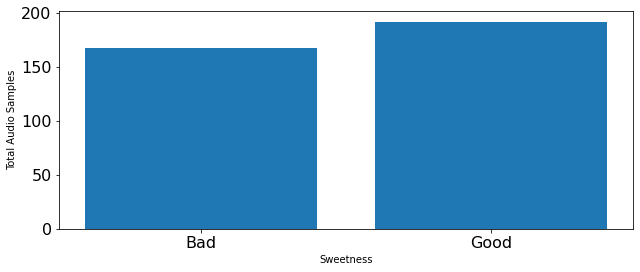

In [31]:
# plot dist
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
sweetness_list, count = np.unique(labels, return_counts=True)
plt.bar(x=range(2), height=count)
plt.xticks(ticks=range(2), labels = [sweetness for sweetness in sweetness_list],fontsize=10)
plt.xlabel('Sweetness')
plt.tick_params(labelsize=16)
plt.ylabel('Total Audio Samples')
plt.show()



In [32]:
print(f"Accuracy to beat: {np.max(count)/np.sum(count)}")

Accuracy to beat: 0.5333333333333333
